# Homework 2

1. Анализ датасета. Каков баланс классов (положительный, негативный, отрицательный) в данном датасете?
Сколько авиалиний представлено в датасете (колонка airline)?
Каково соотношение классов для каждой авиалинии?

2. Постройте гистограмму распределения длин текстов в датасете (в символах, а лучше в токенах)

3. Реализуйте еще хотя бы один-два шага для подготовки и нормализации текстов ( из тех, что обсуждали, но не реализовали на занятии, например, хотя бы почистить текст от пунктуации и спец. символов). 

4. Векторизируйте тексты с помощью tf idf. Используйте получившиеся вектора, чтобы обучить Knn классификатор (можете использовать кросс валидацию и поиск по сетке). Оцените его качество

5. Поэкспериментируйте с параметрами tf idf векторизатора из sklearn. Нпаример, выберете иные max_features, binary, min max df, ngram range  и т.д. Попробуйте подобрать такие параметры, которые улучшат качество модели.

6. (OPTIONAL) Поэкспериментируйте с разными токенайзерами. Попробуйте найти тот, что на Ваш взгляд дает лучший результат. Возможно,  это поможет еще больше улучшить качество модели

## Task 1. Dataset Analysis. Class balance

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Tweets.csv')

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [5]:
# Checking the class balance in the dataset
class_counts = data['airline_sentiment'].value_counts()
print(f"Overall class Balance: \n{class_counts}")

Overall class Balance: 
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [6]:
# Finding the number of airlines represented in the dataset
airlines = data['airline'].unique()
num_airlines = len(airlines)
print(f"Number of Airlines Represented: {num_airlines} - {airlines}")

Number of Airlines Represented: 6 - ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


In [7]:
# Calculating the class ratio for each airline
for airline in airlines:
    airline_df = data[data['airline'] == airline]
    class_ratios = airline_df['airline_sentiment'].value_counts()
    print(f"Class Ratios for {airline}: \n{class_ratios}\n")

Class Ratios for Virgin America: 
negative    181
neutral     171
positive    152
Name: airline_sentiment, dtype: int64

Class Ratios for United: 
negative    2633
neutral      697
positive     492
Name: airline_sentiment, dtype: int64

Class Ratios for Southwest: 
negative    1186
neutral      664
positive     570
Name: airline_sentiment, dtype: int64

Class Ratios for Delta: 
negative    955
neutral     723
positive    544
Name: airline_sentiment, dtype: int64

Class Ratios for US Airways: 
negative    2263
neutral      381
positive     269
Name: airline_sentiment, dtype: int64

Class Ratios for American: 
negative    1960
neutral      463
positive     336
Name: airline_sentiment, dtype: int64



## Task 2. Text length plotting

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


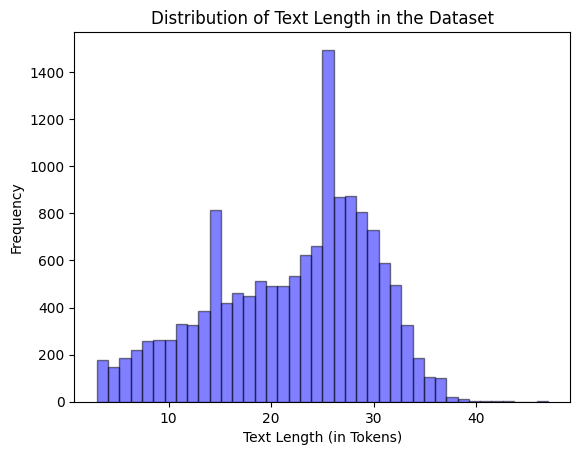

In [8]:
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')

# Calculating the length of each text in the dataset in tokens
data['text_length'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x)))

# Plotting the histogram of text length distribution
plt.hist(data['text_length'], bins=40, alpha=0.5, color='blue', edgecolor='black')
plt.xlabel('Text Length (in Tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length in the Dataset')
plt.show()

In [9]:
# Average text length
data['text_length'].mean()

21.97827868852459

## Task 3. Text preprocessing

In [10]:
!pip install emoji -q


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\email\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
import re
import emoji
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
# Cleaning up the text by removing punctuation and special characters
def clean_text_nltk(text):
    # Text to lowercase
    text = text.lower()
    # Removing punctuation and special characters
    text = text.translate(str.maketrans('', '', "“”" + string.punctuation.replace('@', '')))
    
    # Cleaning up stopwords, emojis, links and tags + lemmatization
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'http[^\s]+', '', text)
    text = re.sub(r'@\w+', '', text)

    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    text = ' '.join(words)
    return text

In [64]:
data['text_clean'] = data['text'].apply(clean_text_nltk)

In [65]:
data['text'].to_list()[:20]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica plus you've added commercials to the experience... tacky.",
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24',
 '@VirginAmerica I &lt;3 pretty graphic

In [66]:
data['text_clean'].to_list()[:20]

['said',
 'plus youve added commercial experience tacky',
 'didnt today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guest face amp little recourse',
 'really big bad thing',
 'seriously would pay 30 flight seat didnt playing really bad thing flying va',
 'yes nearly every time fly vx ear worm ’ go away',
 'really missed prime opportunity men without hat parody',
 'well didnt…but',
 'amazing arrived hour early youre good',
 'know suicide second leading cause death among teen 1024',
 'lt3 pretty graphic much better minimal iconography',
 'great deal already thinking 2nd trip amp havent even gone 1st trip yet p',
 'im flying fabulous seductive sky u take stress away travel',
 'thanks',
 'sfopdx schedule still mia',
 'excited first cross country flight lax mco ive heard nothing great thing virgin america 29daystogo',
 'flew nyc sfo last week couldnt fully sit seat due two large gentleman either side help',
 'flying',
 'know would amazingly awesome b

## Task 4-5. TF-IDF text vectorization and KNN Classifier fitting

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import numpy as np

In [18]:
# Encoding data labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['labels'] = label_encoder.fit_transform(data['airline_sentiment'])

In [19]:
X = data['text_clean'].values

In [20]:
Y = data['labels'].values

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

In [26]:
parameter_grid = {'vect__max_features': [1000, 1500],
              'vect__min_df': [4, 9],
              'vect__max_df': [0.6, 0.9],
              'vect__ngram_range': [(1, 2), (1, 3)],
              'clf__n_neighbors': [5, 7, 9],
              'clf__metric': ['cosine', 'euclidean']}

In [27]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('clf', KNeighborsClassifier()),
    ]
)

In [28]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameter_grid, cv=5, verbose=3)

In [ ]:
grid_search.fit(x_train, y_train)

In [44]:
grid_search.best_params_

{'clf__metric': 'cosine',
 'clf__n_neighbors': 9,
 'vect__max_df': 0.6,
 'vect__max_features': 1500,
 'vect__min_df': 4,
 'vect__ngram_range': (1, 2)}

In [43]:
# Getting the best pipeline from the grid search
best_pipeline = grid_search.best_estimator_

# Extracting the best vectorizer and classifier from the pipeline
best_vectorizer = best_pipeline.steps[0][1]
best_classifier = best_pipeline.steps[1][1]

In [57]:
# Combining the training data and test data
x_combined = np.concatenate([x_train, x_test])

# Fitting the vectorizer on the combined data
best_vectorizer.fit(x_combined)

# Vectorizing the x_test data using the best vectorizer
x_test_vectorized = best_vectorizer.transform(x_test)

In [96]:
x_train_vectorized = best_vectorizer.transform(x_train)
best_classifier.fit(x_train_vectorized, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=9)

In [99]:
# Predictions on the test data
y_pred = best_classifier.predict(x_test_vectorized)

# Evaluating the model using accuracy, F1-score, recall, and precision
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5259562841530054
F1-score: 0.38488100740534215
Recall: 0.3782380388292706
Precision: 0.4168140858064758
Confusion Matrix:
 [[1307  413  106]
 [ 434  139   38]
 [ 327   70   94]]


## Task 6. 

#### Preprocessing with SpaCy

In [78]:
# Cleaning up the text by removing punctuation and special characters
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def clean_text_spacy(text):
    # Removing punctuation and special characters
    text = text.translate(str.maketrans('', '', "“”" + string.punctuation.replace('@', '')))
    
    # Clean up stopwords, emojis, links and tags + lemmatization
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'http[^\s]+', '', text)
    text = re.sub(r'@\w+', '', text)

    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.text.lower() not in STOP_WORDS]
    text = ' '.join(tokens).strip()
    return text

In [79]:
data['text_clean_spacy'] = data['text'].apply(clean_text_spacy)

In [80]:
data['text_clean_spacy'].to_list()[:20]

['say',
 'plus ve add commercial experience tacky',
 'not today mean need trip',
 'aggressive blast obnoxious entertainment guest face amp little recourse',
 'big bad thing',
 'seriously pay 30 flight seat not playing \n bad thing fly va',
 'yes nearly time fly vx ear worm will away',
 'miss prime opportunity men hats parody',
 'didnt … d',
 'amazing arrive hour early good',
 'know suicide second lead cause death teen 1024',
 'lt3 pretty graphic well minimal iconography d',
 'great deal think 2nd trip   amp not go 1st trip p',
 'm fly fabulous seductive sky u stress away travel',
 'thank',
 'sfopdx schedule mia',
 'excited cross country flight lax mco ve hear great thing virgin america 29daystogo',
 'fly nyc sfo week not fully sit seat large gentleman help',
 'fly',
 'know amazingly awesome bosfll want fly']

In [84]:
X = data['text_clean_spacy'].values

In [85]:
Y = data['labels'].values

In [87]:
x_train_copy, x_test_copy, y_train_copy, y_test_copy = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

In [88]:
from sklearn import clone

In [89]:
# Getting the best pipeline from the grid search
best_pipeline_copy = clone(grid_search.best_estimator_)

# Extracting the best vectorizer and classifier from the pipeline
best_vectorizer_copy = best_pipeline_copy.steps[0][1]
best_classifier_copy = best_pipeline_copy.steps[1][1]

In [100]:
x_combined_copy = np.concatenate([x_train_copy, x_test_copy])

In [101]:
# Fitting the vectorizer on the combined data
best_vectorizer_copy.fit(x_combined_copy)

# Vectorizing the x_test data using the best vectorizer
x_test_vectorized_copy = best_vectorizer_copy.transform(x_test_copy)

In [102]:
x_train_vectorized_copy = best_vectorizer_copy.transform(x_train_copy)
best_classifier_copy.fit(x_train_vectorized_copy, y_train_copy)

KNeighborsClassifier(metric='cosine', n_neighbors=9)

In [103]:
# Predictions on the test data
y_pred = best_classifier_copy.predict(x_test_vectorized_copy)

# Evaluating the model using accuracy, F1-score, recall, and precision
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6980874316939891
F1-score: 0.6038667892378888
Recall: 0.5817050641472914
Precision: 0.6436529030798129
Confusion Matrix:
 [[1555  215   56]
 [ 313  256   42]
 [ 183   75  233]]


**->** SpaCy preprocessing improved the classifier performance. In terms of lemmatization it works significantly better.